In [1]:
# Copyright (c) 2024，WuChao D-Robotics.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import cv2
import numpy as np
from scipy.special import softmax
# from scipy.special import expit as sigmoid
from time import time
from hobot_dnn import pyeasy_dnn as dnn  # BSP Python API

In [2]:
coco_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", 
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", 
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", 
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

rdk_colors = [
    (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255),(49, 210, 207), (10, 249, 72), (23, 204, 146), (134, 219, 61),
    (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0),(147, 69, 52), (255, 115, 100), (236, 24, 0), (255, 56, 132),
    (133, 0, 82), (255, 56, 203), (200, 149, 255), (199, 55, 255)]

def draw_detection(img: np.array, 
                   box: tuple[int, int, int, int],
                   score: float, 
                   class_id: int) -> None:
    x1, y1, x2, y2 = box
    color = rdk_colors[class_id%20]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    label = f"{coco_names[class_id]}: {score:.2f}"
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# matplotlib 绘制图像到 Jupyter Web
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(cv2_img: np.ndarray)-> np.ndarray:
    if cv2_img.ndim==3: # Color image, Convert BGR to RGB
        return cv2_img[:,:,::-1] 
    else: # Grayscale image
        return cv2_img

def jshow(cv2_img: np.ndarray, size: int = 4)-> None:
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

def bgr2nv12_opencv(image: np.ndarray) -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    area = height * width
    yuv420p = cv2.cvtColor(image, cv2.COLOR_BGR2YUV_I420).reshape((area * 3 // 2,))
    y = yuv420p[:area]
    uv_planar = yuv420p[area:].reshape((2, area // 4))
    uv_packed = uv_planar.transpose((1, 0)).reshape((area // 2,))

    nv12 = np.zeros_like(yuv420p)
    nv12[:height * width] = y
    nv12[height * width:] = uv_packed
    return nv12

In [131]:
# 导入bin模型
model_path = "models/yolov8x_detect_bayese_640x640_nv12_modified.bin"
begin_time = time()
quantize_model = dnn.load(model_path)
print("\033[1;31m" + f"Load D-Robotics Quantize model time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print("-> input tensors")
for i, quantize_input in enumerate(quantize_model[0].inputs):
    print(f"intput[{i}], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

print("-> output tensors")
for i, quantize_input in enumerate(quantize_model[0].outputs):
    print(f"output[{i}], name={quantize_input.name}, type={quantize_input.properties.dtype}, shape={quantize_input.properties.shape}")

[W][DNN]bpu_model_info.cpp:491][Version](2024-12-11,20:25:24.204.428) Model: yolov8n_detect_bayese_640x640_nv12. Inconsistency between the hbrt library version 3.15.54.0 and the model build version 3.15.55.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.
[A][DNN][packed_model.cpp:247][Model](2024-12-11,21:18:15.835.452) [HorizonRT] The model builder version = 1.24.3
Load D-Robotics Quantize model time = 1379.73 ms
-> input tensors
intput[0], name=images, type=uint8, shape=(1, 3, 640, 640)
-> output tensors
output[0], name=output0, type=float32, shape=(1, 80, 80, 80)
output[1], name=538, type=int32, shape=(1, 80, 80, 64)
output[2], name=546, type=float32, shape=(1, 40, 40, 80)
output[3], name=554, type=int32, shape=(1, 40, 40, 64)
output[4], name=562, type=float32, shape=(1, 20, 20, 80)
output[5], name=570, type=int32, shape=(1, 20, 20, 64)


In [132]:
# 提前将反量化系数准备好
s_bboxes_scale = quantize_model[0].outputs[1].properties.scale_data[np.newaxis, :]
m_bboxes_scale = quantize_model[0].outputs[3].properties.scale_data[np.newaxis, :]
l_bboxes_scale = quantize_model[0].outputs[5].properties.scale_data[np.newaxis, :]
print(f"{s_bboxes_scale.shape=}, {m_bboxes_scale.shape=}, {l_bboxes_scale.shape=}")

# DFL求期望的系数, 只需要生成一次
weights_static = np.array([i for i in range(16)]).astype(np.float32)[np.newaxis, np.newaxis, :]
print(f"{weights_static.shape = }")

# 输入图像大小, 一些阈值, 提前计算好
REG = 16
print(f"{REG = }")

CLASSES_NUM = 80
print(f"{CLASSES_NUM = }")

SCORE_THRESHOLD = 0.25
NMS_THRESHOLD = 0.85
CONF_THRES_RAW = -np.log(1/SCORE_THRESHOLD - 1)
print("SCORE_THRESHOLD  = %.2f, NMS_THRESHOLD = %.2f"%(SCORE_THRESHOLD, NMS_THRESHOLD))
print("CONF_THRES_RAW = %.2f"%CONF_THRES_RAW)

input_H, input_W = quantize_model[0].inputs[0].properties.shape[2:4]
print(f"{input_H = }, {input_W = }")

RESIZE_TYPE = 0
LETTERBOX_TYPE = 1
PREPROCESS_TYPE = LETTERBOX_TYPE
print("LETTERBOX_TYPE" if PREPROCESS_TYPE == LETTERBOX_TYPE else "PREPROCESS_TYPE")

# grid, 只需要生成一次
s_grid = np.stack([np.tile(np.linspace(0.5, 79.5, 80), reps=80), 
                     np.repeat(np.arange(0.5, 80.5, 1), 80)], axis=0).transpose(1,0)
m_grid = np.stack([np.tile(np.linspace(0.5, 39.5, 40), reps=40), 
                     np.repeat(np.arange(0.5, 40.5, 1), 40)], axis=0).transpose(1,0)
l_grid = np.stack([np.tile(np.linspace(0.5, 19.5, 20), reps=20), 
                     np.repeat(np.arange(0.5, 20.5, 1), 20)], axis=0).transpose(1,0)
print(f"{s_grid.shape = }  {m_grid.shape = }  {l_grid.shape = }")

s_bboxes_scale.shape=(1, 64), m_bboxes_scale.shape=(1, 64), l_bboxes_scale.shape=(1, 64)
weights_static.shape = (1, 1, 16)
REG = 16
CLASSES_NUM = 80
SCORE_THRESHOLD  = 0.25, NMS_THRESHOLD = 0.85
CONF_THRES_RAW = -1.10
input_H = 640, input_W = 640
LETTERBOX_TYPE
s_grid.shape = (6400, 2)  m_grid.shape = (1600, 2)  l_grid.shape = (400, 2)


cv2.imread time = 14.41 ms
img.shape = (480, 640, 3)


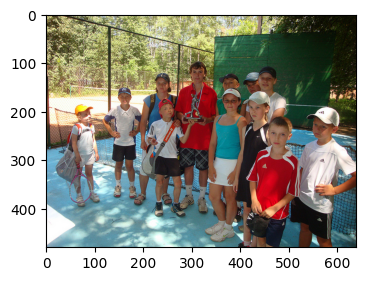

pre process(letter box) time = 5.23 ms
input_tensor.shape = (614400,)


In [133]:
# 读取一张bgr8格式的图像, 并进行可视化
begin_time = time()
img = cv2.imread("../../../resource/DataSets/val2017/000000001000.jpg")
print("\033[1;31m" + f"cv2.imread time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{img.shape = }")
jshow(img)

img_h, img_w = img.shape[0:2]
if PREPROCESS_TYPE == RESIZE_TYPE:
    # 利用resize的方式进行前处理, 准备nv12的输入数据
    begin_time = time()
    input_tensor = cv2.resize(img, (input_W, input_H), interpolation=cv2.INTER_NEAREST) # 利用resize重新开辟内存节约一次
    input_tensor = bgr2nv12_opencv(input_tensor)
    y_scale = 1.0 * input_H / img_h
    x_scale = 1.0 * input_W / img_w
    y_shift = 0;
    x_shift = 0;
    print("\033[1;31m" + f"pre process(resize) time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
    print(f"{input_tensor.shape = }")
elif PREPROCESS_TYPE == LETTERBOX_TYPE:
    # 利用 letter box 的方式进行前处理, 准备nv12的输入数据
    begin_time = time()
    x_scale = min(1.0 * input_H / img_h, 1.0 * input_W / img_w)
    y_scale = x_scale
    
    if x_scale <= 0 or y_scale <= 0:
        raise ValueError("Invalid scale factor.")
    
    new_w = int(img_w * x_scale)
    x_shift = (input_W - new_w) // 2
    x_other = input_W - new_w - x_shift
    
    new_h = int(img_h * y_scale)
    y_shift = (input_H - new_h) // 2
    y_other = input_H - new_h - y_shift
    
    input_tensor = cv2.resize(img, (new_w, new_h))
    
    input_tensor = cv2.copyMakeBorder(input_tensor, y_shift, y_other, x_shift, x_other, cv2.BORDER_CONSTANT, value=[127, 127, 127])
    input_tensor = bgr2nv12_opencv(input_tensor)
    print("\033[1;31m" + f"pre process(letter box) time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
    print(f"{input_tensor.shape = }")
else:
    print(f"illegal PREPROCESS_TYPE = {PREPROCESS_TYPE}")
    exit(-1)

In [134]:
# 推理
begin_time = time()
quantize_outputs = quantize_model[0].forward(input_tensor)
print("\033[1;31m" + f"forward time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

forward time = 95.11 ms


In [135]:
# c to np
begin_time = time()
s_clses = quantize_outputs[0].buffer
s_bboxes = quantize_outputs[1].buffer
m_clses = quantize_outputs[2].buffer
m_bboxes = quantize_outputs[3].buffer
l_clses = quantize_outputs[4].buffer
l_bboxes = quantize_outputs[5].buffer
print("\033[1;31m" + f"c to numpy time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_bboxes.shape = }  {m_bboxes.shape = }  {l_bboxes.shape = }")
print(f"{s_clses.shape = }   {m_clses.shape = }   {l_clses.shape = }")

print(f"{s_bboxes.dtype = }  {m_bboxes.dtype = }  {l_bboxes.dtype = }")
print(f"{s_clses.dtype = }   {m_clses.dtype = }   {l_clses.dtype = }")

c to numpy time = 3.79 ms
s_bboxes.shape = (1, 80, 80, 64)  m_bboxes.shape = (1, 40, 40, 64)  l_bboxes.shape = (1, 20, 20, 64)
s_clses.shape = (1, 80, 80, 80)   m_clses.shape = (1, 40, 40, 80)   l_clses.shape = (1, 20, 20, 80)
s_bboxes.dtype = dtype('int32')  m_bboxes.dtype = dtype('int32')  l_bboxes.dtype = dtype('int32')
s_clses.dtype = dtype('float32')   m_clses.dtype = dtype('float32')   l_clses.dtype = dtype('float32')


In [136]:
# reshape
begin_time = time()
s_bboxes = s_bboxes.reshape(-1, REG * 4)
m_bboxes = m_bboxes.reshape(-1, REG * 4)
l_bboxes = l_bboxes.reshape(-1, REG * 4)
s_clses = s_clses.reshape(-1, CLASSES_NUM)
m_clses = m_clses.reshape(-1, CLASSES_NUM)
l_clses = l_clses.reshape(-1, CLASSES_NUM)
print("\033[1;31m" + f"reshape time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_bboxes.shape = }  {m_bboxes.shape = }  {l_bboxes.shape = }")
print(f"{s_clses.shape = }   {m_clses.shape = }   {l_clses.shape = }")

print(f"{s_bboxes.dtype = }  {m_bboxes.dtype = }  {l_bboxes.dtype = }")
print(f"{s_clses.dtype = }   {m_clses.dtype = }   {l_clses.dtype = }")

reshape time = 1.11 ms
s_bboxes.shape = (6400, 64)  m_bboxes.shape = (1600, 64)  l_bboxes.shape = (400, 64)
s_clses.shape = (6400, 80)   m_clses.shape = (1600, 80)   l_clses.shape = (400, 80)
s_bboxes.dtype = dtype('int32')  m_bboxes.dtype = dtype('int32')  l_bboxes.dtype = dtype('int32')
s_clses.dtype = dtype('float32')   m_clses.dtype = dtype('float32')   l_clses.dtype = dtype('float32')


In [137]:
# classify: 利用numpy向量化操作完成阈值筛选（优化版 2.0）
begin_time = time()
s_max_scores = np.max(s_clses, axis=1)
s_valid_indices = np.flatnonzero(s_max_scores >= CONF_THRES_RAW)  # 得到大于阈值分数的索引，此时为小数字
s_ids = np.argmax(s_clses[s_valid_indices, : ], axis=1)
s_scores = s_max_scores[s_valid_indices]

m_max_scores = np.max(m_clses, axis=1)
m_valid_indices = np.flatnonzero(m_max_scores >= CONF_THRES_RAW)  # 得到大于阈值分数的索引，此时为小数字
m_ids = np.argmax(m_clses[m_valid_indices, : ], axis=1)
m_scores = m_max_scores[m_valid_indices]

l_max_scores = np.max(l_clses, axis=1)
l_valid_indices = np.flatnonzero(l_max_scores >= CONF_THRES_RAW)  # 得到大于阈值分数的索引，此时为小数字
l_ids = np.argmax(l_clses[l_valid_indices, : ], axis=1)
l_scores = l_max_scores[l_valid_indices]
print("\033[1;31m" + f"Small, Medium, Big Feature Map Conf Threshold time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_scores.shape = }  {s_ids.shape = }  {s_valid_indices.shape = }")
print(f"{m_scores.shape = }  {m_ids.shape = }  {m_valid_indices.shape = }")
print(f"{l_scores.shape = }  {l_ids.shape = }  {l_valid_indices.shape = }")

Small, Medium, Big Feature Map Conf Threshold time = 5.40 ms
s_scores.shape = (37,)  s_ids.shape = (37,)  s_valid_indices.shape = (37,)
m_scores.shape = (109,)  m_ids.shape = (109,)  m_valid_indices.shape = (109,)
l_scores.shape = (24,)  l_ids.shape = (24,)  l_valid_indices.shape = (24,)


In [138]:
# 3个Classify分类分支：Sigmoid计算
begin_time = time()
s_scores = 1 / (1 + np.exp(-s_scores))
m_scores = 1 / (1 + np.exp(-m_scores))
l_scores = 1 / (1 + np.exp(-l_scores))
print("\033[1;31m" + f"sigmoid time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

sigmoid time = 0.94 ms


In [139]:
# 3个Bounding Box分支：反量化
begin_time = time()
s_bboxes_float32 = s_bboxes[s_valid_indices,:].astype(np.float32) * s_bboxes_scale
m_bboxes_float32 = m_bboxes[m_valid_indices,:].astype(np.float32) * m_bboxes_scale
l_bboxes_float32 = l_bboxes[l_valid_indices,:].astype(np.float32) * l_bboxes_scale
print("\033[1;31m" + f"Bounding Box Dequantized time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_bboxes_float32.shape = }")
print(f"{m_bboxes_float32.shape = }")
print(f"{l_bboxes_float32.shape = }")

Bounding Box Dequantized time = 3.78 ms
s_bboxes_float32.shape = (37, 64)
m_bboxes_float32.shape = (109, 64)
l_bboxes_float32.shape = (24, 64)


In [140]:
# 3个Bounding Box分支：dist2bbox（ltrb2xyxy） transpose
begin_time = time()

s_ltrb_indices = np.sum(softmax(s_bboxes_float32.reshape(-1, 4, 16), axis=2) * weights_static, axis=2)
s_grid_indices = s_grid[s_valid_indices, :]
s_x1y1 = s_grid_indices - s_ltrb_indices[:, 0:2]
s_x2y2 = s_grid_indices + s_ltrb_indices[:, 2:4]
s_dbboxes = np.hstack([s_x1y1, s_x2y2])*8

m_ltrb_indices = np.sum(softmax(m_bboxes_float32.reshape(-1, 4, 16), axis=2) * weights_static, axis=2)
m_grid_indices = m_grid[m_valid_indices, :]
m_x1y1 = m_grid_indices - m_ltrb_indices[:, 0:2]
m_x2y2 = m_grid_indices + m_ltrb_indices[:, 2:4]
m_dbboxes = np.hstack([m_x1y1, m_x2y2])*16

l_ltrb_indices = np.sum(softmax(l_bboxes_float32.reshape(-1, 4, 16), axis=2) * weights_static, axis=2)
l_grid_indices = l_grid[l_valid_indices,:]
l_x1y1 = l_grid_indices - l_ltrb_indices[:, 0:2]
l_x2y2 = l_grid_indices + l_ltrb_indices[:, 2:4]
l_dbboxes = np.hstack([l_x1y1, l_x2y2])*32
print("\033[1;31m" + f"dist2bbox（ltrb2xyxy） time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

dist2bbox（ltrb2xyxy） time = 6.50 ms


In [141]:
# 大中小特征层阈值筛选结果拼接
begin_time = time()
dbboxes = np.concatenate((s_dbboxes, m_dbboxes, l_dbboxes), axis=0)
scores = np.concatenate((s_scores, m_scores, l_scores), axis=0)
ids = np.concatenate((s_ids, m_ids, l_ids), axis=0)
print("\033[1;31m" + f"concat time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{dbboxes.shape = }  {scores.shape = }  {ids.shape = }")

concat time = 1.44 ms
dbboxes.shape = (170, 4)  scores.shape = (170,)  ids.shape = (170,)


In [142]:
results = []
for i in range(CLASSES_NUM):
    id_indices = ids==i
    indices = cv2.dnn.NMSBoxes(dbboxes[id_indices,:], scores[id_indices], SCORE_THRESHOLD, NMS_THRESHOLD)
    if len(indices) == 0:
        continue
    for indic in indices:
        x1, y1, x2, y2 = dbboxes[id_indices,:][indic]
        x1 = int((x1 - x_shift) / x_scale)
        y1 = int((y1 - y_shift) / y_scale)
        x2 = int((x2 - x_shift) / x_scale)
        y2 = int((y2 - y_shift) / y_scale)
        results.append((i, scores[id_indices][indic], x1, y1, x2, y2))

(503, 190, 639, 476) -> person: 0.95
(116, 150, 196, 380) -> person: 0.93
(412, 212, 526, 477) -> person: 0.92
(326, 153, 416, 471) -> person: 0.91
(265, 98, 354, 410) -> person: 0.91
(50, 186, 113, 391) -> person: 0.85
(391, 158, 463, 477) -> person: 0.83
(203, 174, 306, 418) -> person: 0.83
(191, 121, 271, 392) -> person: 0.73
(352, 122, 402, 209) -> person: 0.60
(437, 106, 498, 225) -> person: 0.58
(406, 119, 441, 165) -> person: 0.48
(401, 119, 442, 229) -> person: 0.43
(360, 122, 400, 159) -> person: 0.32
(402, 108, 497, 229) -> person: 0.31
(198, 222, 268, 341) -> handbag: 0.57
(413, 406, 463, 461) -> handbag: 0.43
(47, 308, 94, 391) -> tennis racket: 0.79
(213, 255, 231, 295) -> wine glass: 0.35


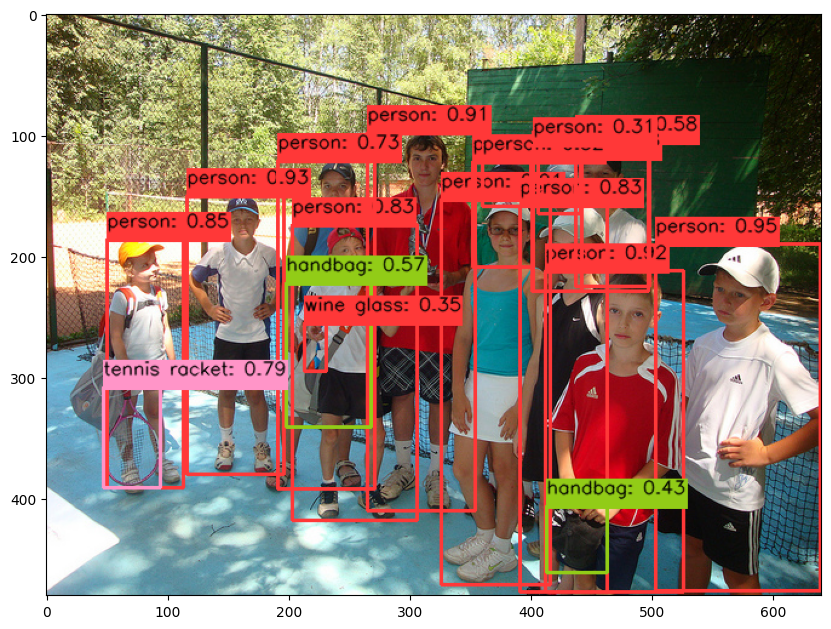

Draw Result time = 1141.42 ms


In [144]:
# 绘制
draw_img = img.copy()
begin_time = time()
for class_id, score, x1, y1, x2, y2 in results:
    print("(%d, %d, %d, %d) -> %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(draw_img, (x1, y1, x2, y2), score, class_id)
jshow(draw_img, 10)
print("\033[1;31m" + f"Draw Result time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

In [83]:
# nms
begin_time = time()
indices = cv2.dnn.NMSBoxes(dbboxes, scores, SCORE_THRESHOLD, NMS_THRESHOLD)
print("\033[1;31m" + f"nms time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{len(indices) = }")

nms time = 0.93 ms
len(indices) = 5


In [84]:
# 整理
bboxes = dbboxes[indices] * np.array([x_scale, y_scale, x_scale, y_scale])
bboxes = bboxes.astype(np.int32)
scores = scores[indices]
ids = ids[indices]

In [85]:
# 绘制
draw_img = img.copy()
begin_time = time()
for class_id, score, bbox in zip(ids, scores, bboxes):
    x1, y1, x2, y2 = bbox
    print("(%d, %d, %d, %d) -> %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(draw_img, (x1, y1, x2, y2), score, class_id)

print("\033[1;31m" + f"Draw Result time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

(55, 79, 327, 270) -> bus: 0.80
(64, 139, 129, 318) -> person: 0.75
(125, 143, 167, 300) -> person: 0.71
(282, 136, 332, 307) -> person: 0.67
(47, 195, 68, 303) -> person: 0.26
Draw Result time = 5.21 ms


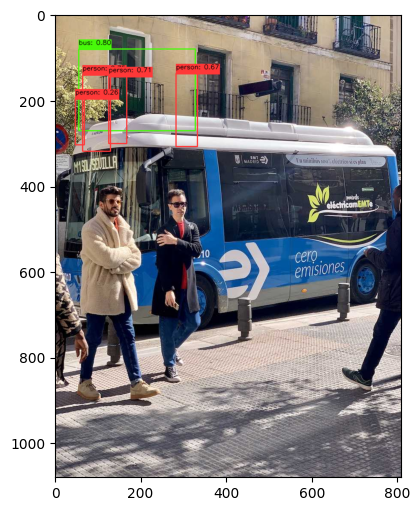

In [86]:
jshow(draw_img, 6)

In [ ]:
# 保存
begin_time = time()
cv2.imwrite("jupyter_result.jpg", draw_img)
print("\033[1;31m" + f"cv2.imwrite time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")